In [41]:
import numpy as np
from math import e
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [79]:
class Line():
    def __init__(self, p):
        self.m1, self.m2, self.b = np.random.uniform(10.0,10.0,3)
        super().__init__()
    def calculate(self,x):
        x1,x2 = x
        return self.m1*x1+self.m2*x2+self.b
    
    def find_actual_y(self,X):
        return [self.calculate(x) for x in X]

    
class Plot:
    def plot_ein(self):
        preds = self.calculate_preds(self.Xorig)
        data = np.concatenate([np.array(self.Xorig),np.array(preds).reshape(-1,1)],axis=1)
        df = pd.DataFrame(data, columns = ["x1","x2","y"])
        sns.scatterplot(data=df, x="x1", y="x2", hue="y")
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.show()
        
    def plot_eout(self):
        X = np.random.uniform(-1.0,1.0,(1000,2))
        preds = self.calculate_preds(X)
        data = np.concatenate([np.array(X),np.array(preds).reshape(-1,1)],axis=1)
        df = pd.DataFrame(data, columns = ["x1","x2","y"])
        sns.scatterplot(data=df, x="x1", y="x2", hue="y")
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.show()
        
        X = np.random.uniform(-1.0,1.0,(1000,2))
        preds = self.calculate_preds(X)
        y = self.find_actual_y(X)
        plt.plot(y,preds,"go")
        plt.plot(y,y,"bo")
        plt.vlines(y, y, preds, colors='k', linestyles='solid', label='')
        plt.show()
    

class NeuralNetwork(Line,Plot):
    def __init__(self):
        self.N = 100
        self.input = 2
        self.N_var_layer1 = 3
        self.N_var_layer2 = 4
        self.N_var_layer3 = 1 #output
        self.layers = [self.N_var_layer1, self.N_var_layer2, self.N_var_layer3]
        self.n = .1
        self.N_layers = len(self.layers)
        
        #initialize weights
        self.weights1 = np.random.uniform(-1.0,1.0,(self.N_var_layer2-1,self.N_var_layer1)) # shape =(#j (outputs), #i (inputs))
        self.weights2 = np.random.uniform(-1.0,1.0,(self.N_var_layer3,self.N_var_layer2))
        self.weights = [self.weights1,self.weights2]
        
        #Create points
        self.create_line()
        self.Xorig = np.random.uniform(-1.0,1.0,(self.N,self.input))
        self.y = self.find_actual_y(self.Xorig)
        self.X = np.concatenate([[[1]for x in range(len(self.Xorig))],self.Xorig],axis=1)

        #Run SGD
        self.num_iter = 0
        self.ein = self.mse(self.X,self.y)
        print("Pre Adjusting Ein %s" % self.ein)
        hump = 0
        for x in range(1000):
            wt = self.vals()
            self.num_iter += 1
            self.sgd_epoch()
            wt1 = self.vals()
            if np.sqrt(sum((wt-wt1)**2)) <.01: #np.linalg.norm
                hump += 1
                if hump>1000:
                    break
            
        print("Final Weights %s" % self.weights)      
        print("Num Iterations %s" %self.num_iter)
        self.ein = self.mse(self.X,self.y)
        print("Ein %s" % self.ein)
        
        self.eout = self.eout()
        print("Eout %s" % self.eout)
        
        self.plot_ein()
        self.plot_eout()
        
    def create_line(self):
        p = np.random.uniform(-1.0,1.0,(2,2))
        while p[0][0] == p[1][0] and p[0][1] == p[1][1]:
            p = [np.random.uniform(-1.0,1.0,2) for x in range(2)]
        super().__init__(p)
         
        
        
####################################################
    def vals(self):
        change = []
        for layer in range(2,self.N_layers+1):
                layer_m1 = layer -1
                jss = [0] if layer == self.N_layers else range(self.layers[layer-1]-1)
                iss = range(self.layers[layer_m1-1]) 
                change += [self.weights[layer_m1-1][j][i] for i in iss for j in jss]
        return np.array(change) 
    
    def pickRandomPoint(self):
        val = random.randint(0,self.N-1)
        return self.X[val], self.y[val]
        
    def calculate_xjLs(self,x):
        xjLs = [x]
        for layer in range(self.N_layers-1):
            x_l = [1] if layer != self.N_layers-2 else [] #self.N_layers-2 bc layer 2nd gives layer 3 and layer 2nd is actually 1
            weights_for_layer = self.weights[layer]
            for w_jl in weights_for_layer: #picking specific weights of one output (j)
                x_jl = self.tahn(np.matmul(x,w_jl.T))
                x_l.append(x_jl)
            xjLs.append(x_l)
            x = x_l
        return xjLs
    
    def tahn(self,sj):
        return (e**sj-e**-sj)/(e**sj+e**-sj)
    
    def derivative_of_tahn(self,tahn_s):
        return (1-(tahn_s)**2)
    
    def calculate_deltaL(self,x,y):
        x_1_L = self.xjLs[self.N_layers-1][0]
        return [(x_1_L-y)*self.derivative_of_tahn(x_1_L)]
    
    def calculate_deltas(self,layer,deltas_layer):
        #when layer is three gives deltas for two (already made deltaL), when layer is 2 it gives deltas for 1 --> stop at layer 2
        if layer == 2:
            return [deltas_layer]
        layer_m1 = layer-1
        d_layer = [1] if layer == self.N_layers else range(1,self.layers[layer_m1]) 
        d_layer_m1 = range(1,self.layers[layer_m1-1]) 
        
        deltas_layer_m1_i = []
        
        for i in d_layer_m1:
            sum_of_j_paths = 0
            for j in d_layer:
                deltaj = deltas_layer[j-1]
                sum_of_j_paths += deltaj*self.weights[layer_m1-1][j-1][i] 
                #j-1 because the weights for j=1 are actually the first weights as j=0 is 1
            
            delta_layer_m1_i = self.derivative_of_tahn(self.xjLs[layer_m1-1][i]) * sum_of_j_paths
            deltas_layer_m1_i.append(delta_layer_m1_i)
            
        return self.calculate_deltas(layer-1,deltas_layer_m1_i) + [deltas_layer]
        
    
####################################################
    
    
    def sgd_gradient(self):
        for layer in range(2,self.N_layers+1):
            layer_m1 = layer-1 #wij_2 where 2=layer is the weights between layer 1 (layer-1) and layer 2 (layer)
            delta_layer = self.deltas[layer-2] #delta layer 2 is the first delta at index 0
            for j in range(1,self.layers[layer-1]):
                deltaj_l = delta_layer[j-1]
                for i in range(self.layers[layer_m1-1]):
                    wij_l = self.weights[layer_m1-1][j-1][i]#weights for layer 1 to go to layer 2 is at index 0
                    xi_layer_m1 = self.xjLs[layer_m1-1][i]
                    gradient = -self.n*xi_layer_m1*deltaj_l
                    self.weights[layer_m1-1][j-1][i] = wij_l + gradient
        
        
        
    def sgd_epoch(self):
        vals = list(range(self.N))
        random.shuffle(vals)
        for v in vals:
            x, y = self.X[v],self.y[v]
            self.xjLs = self.calculate_xjLs(x)
            self.deltaL = self.calculate_deltaL(x,y)
            self.deltas = self.calculate_deltas(self.N_layers,self.deltaL)
            self.sgd_gradient()
        return self.weights 
    
    
######################################################
        
    def mse(self,X,y):
        w = self.weights
        return sum([(self.calculate_xjLs(X[v])[-1][0] - y[v])**2 for v in range(len(X))])/len(X)
    
    def calculate_preds(self,X):
        X = np.concatenate([[[1]for x in range(len(X))],X],axis=1)
        return [self.calculate_xjLs(x)[-1][0] for x in X]
        
    
    def eout(self):
        Xorig = np.random.uniform(-1.0,1.0,(100,2))
        X = np.concatenate([[[1]for x in range(len(Xorig))],Xorig],axis=1)
        y = self.find_actual_y(Xorig)
        return self.mse(X,y)

    

   

Pre Adjusting Ein 193.5535650836673
Final Weights [array([[ 7.65505876,  6.92511163,  7.40750175],
       [-4.62317428, -0.67905615, -0.74698242],
       [10.50831365,  9.63810893, 10.27862063]]), array([[-0.42375309,  0.11495724, -0.02195434,  0.48284731]])]
Num Iterations 1000
Ein 176.98872461661804
Eout 167.25004339549102


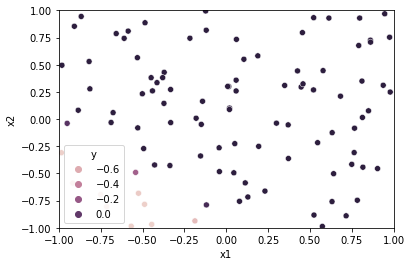

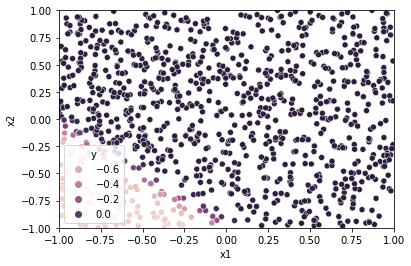

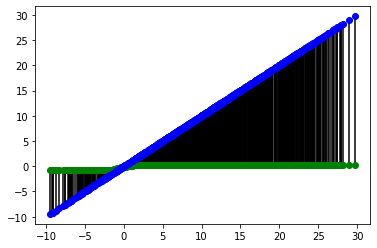

In [80]:
NeuralNetwork()

In [ ]:
#regressor doesn't work because tan is -1 through 1